In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import plumed
import os

In [2]:
# small utility to clean up backup files:
def clean():
    print(subprocess.run("rm -f \#*; rm -fr bck.*",shell=True))
# small utility to run with mpiexec
def run_mpi(cmd,nprocs=1):
    return subprocess.run("""
module load intel/2021.1 gcc openmpi3 cuda
export PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so
export LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH
export PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH
mpiexec -np {} {}
""".format(nprocs,cmd),shell=True)
def parse_log(path="md.log"):
    with open(path,"r") as f:
        found=False
        for l in f:
            ll=l.split()
            if len(ll)>1 and ll[0]=="Core" and ll[1]=="t":
                found=True
            if found:
                print(l,end="")
clean()

CompletedProcess(args='rm -f \\#*; rm -fr bck.*', returncode=0)


In [3]:
# check executables
run_mpi("gmx_mpi")

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 gmx_mpi\n', returncode=0)

In [4]:
run_mpi("plumed")

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 plumed\n', returncode=0)

## Exercise 1a

In this first exercise, we optimize the settings for the METAD action.

We first compute the basic performance using the recommended input file.

In [5]:
with open("plumed-a1.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn: COORDINATION GROUPA=NA GROUPB=WAT R_0=0.3 
PRINT ARG=d,cn STRIDE=100 FILE=COLVAR 
METAD ARG=d,cn SIGMA=0.05,0.1 HEIGHT=0.1 PACE=10 BIASFACTOR=5 
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-a1.dat -nsteps 5000 -ntomp 12 -pin on",1)

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 gmx_mpi mdrun -plumed plumed-a1.dat -nsteps 5000 -ntomp 12 -pin on\n', returncode=0)

In [6]:
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:       64.013        5.335     1200.0
                 (ns/day)    (hour/ns)
Performance:      161.995        0.148
Finished mdrun on rank 0 Mon May  3 00:53:21 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     2.468183     2.468183     2.468183     2.468183
PLUMED: 1 Prepare dependencies                          5001     0.009476     0.000002     0.000002     0.000017
PLUMED: 2 Sharing data                                  5001     0.166659     0.000033     0.000031     0.001239
PLUMED: 3 Waiting for data                              5001     0.027409     0.000005     0.000005     0.000048
PLUMED: 4 Calculating (forward loop)                    5001     1.608278     0.000322     0.000297     0.002222
PLUMED: 4A 0 @0                                         5001     0.006542     0.000001     0.

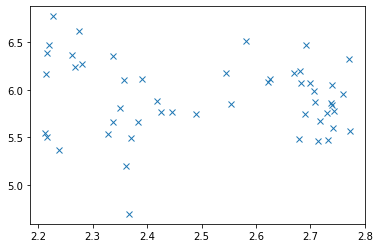

In [7]:
col=plumed.read_as_pandas("COLVAR")
plt.plot(col.d,col.cn,"x")

We then check if the performance changes by using a grid.

In [8]:
with open("plumed-a2.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn: COORDINATION GROUPA=NA GROUPB=WAT R_0=0.3 
PRINT ARG=d,cn STRIDE=100 FILE=COLVAR 
METAD ARG=d,cn SIGMA=0.05,0.1 HEIGHT=0.1 PACE=10 BIASFACTOR=5 GRID_MIN=0,4 GRID_MAX=4,8
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-a2.dat -nsteps 5000 -ntomp 12 -pin on",1)

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 gmx_mpi mdrun -plumed plumed-a2.dat -nsteps 5000 -ntomp 12 -pin on\n', returncode=0)

In [9]:
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:       67.082        5.590     1200.0
                 (ns/day)    (hour/ns)
Performance:      154.585        0.155
Finished mdrun on rank 0 Mon May  3 00:53:31 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     2.476945     2.476945     2.476945     2.476945
PLUMED: 1 Prepare dependencies                          5001     0.009078     0.000002     0.000002     0.000013
PLUMED: 2 Sharing data                                  5001     0.166216     0.000033     0.000030     0.000957
PLUMED: 3 Waiting for data                              5001     0.027279     0.000005     0.000005     0.000020
PLUMED: 4 Calculating (forward loop)                    5001     1.569972     0.000314     0.000295     0.002490
PLUMED: 4A 0 @0                                         5001     0.006467     0.000001     0.

The change is limited, and there's actually a small slowdown... Anyway, we know that on the long run (when we will have many hills) using a grid will be critical for performance. So, we keep on with the grid.

We then test what happens when using a larger PACE (with larger height). Notice that, in the long run, hills height typically become so small (due to BIASFACTOR) that the height of the individual hill will be a tiny fraction of kBT. In this regime, there's no effect in changing PACE, provided that height is changed by the same factor.

In [10]:
with open("plumed-a3.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn: COORDINATION GROUPA=NA GROUPB=WAT R_0=0.3 
PRINT ARG=d,cn STRIDE=100 FILE=COLVAR 
METAD ARG=d,cn SIGMA=0.05,0.1 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0,4 GRID_MAX=4,8
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-a3.dat -nsteps 5000 -ntomp 12 -pin on",1)

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 gmx_mpi mdrun -plumed plumed-a3.dat -nsteps 5000 -ntomp 12 -pin on\n', returncode=0)

In [11]:
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:       64.732        5.394     1200.0
                 (ns/day)    (hour/ns)
Performance:      160.196        0.150
Finished mdrun on rank 0 Mon May  3 00:53:38 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     2.350937     2.350937     2.350937     2.350937
PLUMED: 1 Prepare dependencies                          5001     0.009594     0.000002     0.000002     0.000015
PLUMED: 2 Sharing data                                  5001     0.165980     0.000033     0.000030     0.000980
PLUMED: 3 Waiting for data                              5001     0.027268     0.000005     0.000005     0.000020
PLUMED: 4 Calculating (forward loop)                    5001     1.562554     0.000312     0.000295     0.000847
PLUMED: 4A 0 @0                                         5001     0.006505     0.000001     0.

Little impact. We keep on with these settings, even though for this system we didn't gain much.

## Exercise 1b

Next we proceed in optimizing the calculation of COORDINATION. In order to safely use neighbor lists, we have to make sure that the switching function goes exactly to zero. This can be done by setting D_MAX.

We then test different values of D_MAX, checking if they lead to different values for the COORDINATION variable.

In [12]:
with open("plumed-b1.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn: COORDINATION GROUPA=NA GROUPB=WAT R_0=0.3 
cn1: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75}
cn2: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=1.0}
cn3: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=1.25}
cn4: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=1.5}
PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
METAD ARG=d,cn SIGMA=0.05,0.1 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0,4 GRID_MAX=4,8
PRINT ARG=cn,cn1,cn2,cn3,cn4 FILE=TEST
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-b1.dat -nsteps 5000 -ntomp 12 -pin on",1)

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 gmx_mpi mdrun -plumed plumed-b1.dat -nsteps 5000 -ntomp 12 -pin on\n', returncode=0)

In [13]:
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:      146.201       12.184     1200.0
                 (ns/day)    (hour/ns)
Performance:       70.929        0.338
Finished mdrun on rank 0 Mon May  3 00:53:53 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     8.863930     8.863930     8.863930     8.863930
PLUMED: 1 Prepare dependencies                          5001     0.013864     0.000003     0.000002     0.000015
PLUMED: 2 Sharing data                                  5001     0.166604     0.000033     0.000031     0.000975
PLUMED: 3 Waiting for data                              5001     0.028370     0.000006     0.000005     0.000054
PLUMED: 4 Calculating (forward loop)                    5001     6.702861     0.001340     0.001286     0.003814
PLUMED: 4A  0 @0                                        5001     0.006441     0.000001     0.

In [14]:
test=plumed.read_as_pandas("TEST")
test

,time,cn,cn1,cn2,cn3,cn4
0,0.000,4.695658,4.272987,4.526589,4.618690,4.660486
1,0.002,4.706754,4.284079,4.537718,4.629786,4.671583
2,0.004,4.722637,4.299946,4.553633,4.645667,4.687466
3,0.006,4.743018,4.320321,4.574051,4.666047,4.707848
4,0.008,4.767429,4.344739,4.598499,4.690459,4.732261
...,...,...,...,...,...,...
4996,9.992,6.538183,6.107185,6.364282,6.459519,6.502349
4997,9.994,6.544672,6.113734,6.370780,6.466016,6.508841
4998,9.996,6.551699,6.120827,6.377814,6.473052,6.515872
4999,9.998,6.558974,6.128171,6.385095,6.480335,6.523150


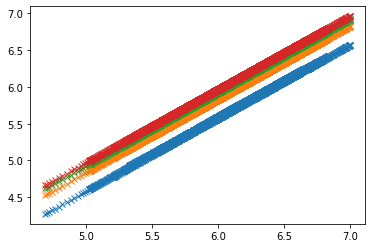

In [15]:
plt.plot(test.cn,test.cn1,"x")
plt.plot(test.cn,test.cn2,"x")
plt.plot(test.cn,test.cn3,"x")
plt.plot(test.cn,test.cn4,"x")

The obtained values are equivalent, though they are related by a uniform shift. It's then certainly fine to use the smallest value (0.75).

We now test neighbor lists. To do so, we try different buffer width and different strides. Notice that a larger buffer (NL_CUTOFF - D_MAX) allows to use a larger stride. However, increasing too much the stride is not useful.

In [16]:
with open("plumed-b2.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn:  COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} 
cn1: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=5
cn2: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=10
cn3: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=20
cn4: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=50
cn5: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=100
cn6: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=200
cn7: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=1.0 NL_STRIDE=5
cn8: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=1.0 NL_STRIDE=10
cn9: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=1.0 NL_STRIDE=20
cn10: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=1.0 NL_STRIDE=50
cn11: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=1.0 NL_STRIDE=100
cn12: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=1.0 NL_STRIDE=200

PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
METAD ARG=d,cn SIGMA=0.05,0.1 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0,4 GRID_MAX=4,8
PRINT ARG=(cn.*) FILE=TEST
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-b2.dat -nsteps 5000 -ntomp 12 -pin on",1)

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 gmx_mpi mdrun -plumed plumed-b2.dat -nsteps 5000 -ntomp 12 -pin on\n', returncode=0)

In [17]:
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:      145.498       12.125     1200.0
                 (ns/day)    (hour/ns)
Performance:       71.272        0.337
Finished mdrun on rank 0 Mon May  3 00:54:07 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     9.287076     9.287076     9.287076     9.287076
PLUMED: 1 Prepare dependencies                          5001     3.521572     0.000704     0.000207     0.006928
PLUMED: 2 Sharing data                                  5001     0.178700     0.000036     0.000032     0.002355
PLUMED: 3 Waiting for data                              5001     0.034216     0.000007     0.000006     0.000070
PLUMED: 4 Calculating (forward loop)                    5001     4.402553     0.000880     0.000671     0.003378
PLUMED: 4A  0 @0                                        5001     0.006737     0.000001     0.

We also compare the values

In [48]:
test=plumed.read_as_pandas("TEST")
test

,time,cn,cn1,cn2,cn3,cn4,cn5,cn6,cn7,cn8,cn9,cn10,cn11,cn12
0,0.000,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987,4.272987
1,0.002,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079,4.284079
2,0.004,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946,4.299946
3,0.006,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321,4.320321
4,0.008,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739,4.344739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,9.992,6.245255,6.245255,6.245255,6.245255,6.245255,6.244778,6.245255,6.245255,6.245255,6.245255,6.245255,6.245255,6.245255
4997,9.994,6.239012,6.239012,6.239012,6.239012,6.239012,6.238558,6.239012,6.239012,6.239012,6.239012,6.239012,6.239012,6.239012
4998,9.996,6.232371,6.232371,6.232371,6.232371,6.232371,6.231943,6.232371,6.232371,6.232371,6.232371,6.232371,6.232371,6.232371
4999,9.998,6.225354,6.225354,6.225354,6.225354,6.225354,6.224954,6.225354,6.225354,6.225354,6.225354,6.225354,6.225354,6.225354


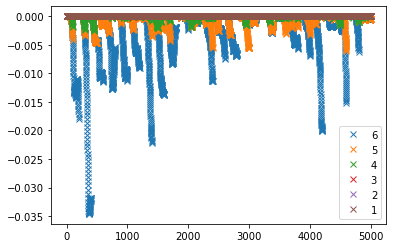

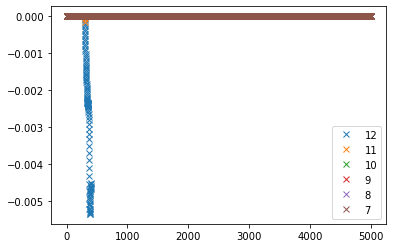

In [19]:
for i in range(6,0,-1):
    plt.plot(test["cn"+str(i)]-test.cn,"x",label=str(i))
plt.legend()
plt.show()
for i in range(12,6,-1):
    plt.plot(test["cn"+str(i)]-test.cn,"x",label=str(i))
plt.legend()
plt.show()

We will use the settings corresponding to cn2:
```
cn2: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=10
```
Notice that cn3 fails in returning the correct value sometime, and all those with NL_CUTOFF=1.0 are slower

In [52]:
np.std(test.cn3-test.cn), np.std(test.cn2-test.cn)

(3.4301432588504727e-06, 0.0)

In [57]:
np.std(test.cn11-test.cn), np.std(test.cn10-test.cn)

(2.4155854084387413e-06, 0.0)

## Exercise 1c

We then try to optimize the number of cores.

In [58]:
with open("plumed-c1.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=10

PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
METAD ARG=d,cn SIGMA=0.05,0.1 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0,4 GRID_MAX=4,8
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-c1.dat -nsteps 5000 -ntomp 12 -pin on",1)
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:       64.213        5.351     1200.0
                 (ns/day)    (hour/ns)
Performance:      161.488        0.149
Finished mdrun on rank 0 Mon May  3 11:33:38 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     1.365028     1.365028     1.365028     1.365028
PLUMED: 1 Prepare dependencies                          5001     0.390627     0.000078     0.000013     0.000662
PLUMED: 2 Sharing data                                  5001     0.158603     0.000032     0.000028     0.000945
PLUMED: 3 Waiting for data                              5001     0.028590     0.000006     0.000005     0.000020
PLUMED: 4 Calculating (forward loop)                    5001     0.399323     0.000080     0.000058     0.000394
PLUMED: 4A 0 @0                                         5001     0.007063     0.000001     0.

In [59]:
run_mpi("gmx_mpi mdrun -plumed plumed-c1.dat -nsteps 5000 -ntomp 6 -pin on",2)
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:       85.823        7.152     1200.0
                 (ns/day)    (hour/ns)
Performance:      120.828        0.199
Finished mdrun on rank 0 Mon May  3 11:33:47 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     1.466897     1.466897     1.466897     1.466897
PLUMED: 1 Prepare dependencies                          5001     0.418080     0.000084     0.000015     0.000567
PLUMED: 2 Sharing data                                  5001     0.157553     0.000032     0.000011     0.000663
PLUMED: 3 Waiting for data                              5001     0.086767     0.000017     0.000012     0.000206
PLUMED: 4 Calculating (forward loop)                    5001     0.471380     0.000094     0.000068     0.001472
PLUMED: 4A 0 @0                                         5001     0.006927     0.000001     0.

In [60]:
run_mpi("gmx_mpi mdrun -plumed plumed-c1.dat -nsteps 5000 -ntomp 24 -pin on",1)
parse_log()

               Core t (s)   Wall t (s)        (%)
       Time:      185.325        7.722     2399.9
                 (ns/day)    (hour/ns)
Performance:      111.908        0.214
Finished mdrun on rank 0 Mon May  3 11:33:57 2021

PLUMED:                                               Cycles        Total      Average      Minimum      Maximum
PLUMED:                                                    1     2.356946     2.356946     2.356946     2.356946
PLUMED: 1 Prepare dependencies                          5001     0.763327     0.000153     0.000026     0.001255
PLUMED: 2 Sharing data                                  5001     0.223939     0.000045     0.000040     0.001713
PLUMED: 3 Waiting for data                              5001     0.050733     0.000010     0.000009     0.000091
PLUMED: 4 Calculating (forward loop)                    5001     0.699776     0.000140     0.000102     0.001356
PLUMED: 4A 0 @0                                         5001     0.010766     0.000002     0.

On this machine it is convenient to use 1 MPI process and 12 threads.

## Exercise 1d

Next we try different settings for metadynamics. We then monitor the number binding/unbinding events that we observe in a fixed simulation time.

I first try to use wider hills

In [61]:
with open("plumed-d1.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=10

PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
METAD ARG=d,cn SIGMA=0.05,0.1 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0,0 GRID_MAX=4,10
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-d1.dat -nsteps 500000 -ntomp 12 -pin on",1)

! mv HILLS HILLS_1
! mv traj_comp.xtc traj_comp1.xtc

with open("plumed-d2.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 
cn: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=10

PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
METAD ARG=d,cn SIGMA=0.1,0.2 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0,0 GRID_MAX=4,10
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-d2.dat -nsteps 500000 -ntomp 12 -pin on",1)

! mv HILLS HILLS_2
! mv traj_comp.xtc traj_comp2.xtc


In [62]:
!plumed sum_hills --hills HILLS_1 --outfile fes1.dat --idw d --kt 2.5
!plumed sum_hills --hills HILLS_2 --outfile fes2.dat --idw d --kt 2.5

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where approp

In [63]:
fes1=plumed.read_as_pandas("fes1.dat")
fes2=plumed.read_as_pandas("fes2.dat")

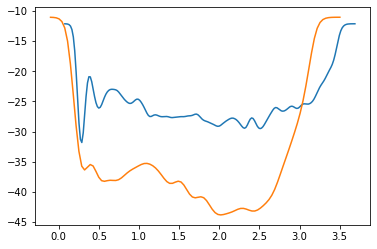

In [64]:
plt.plot(fes1.d,fes1.projection)
plt.plot(fes2.d,fes2.projection)

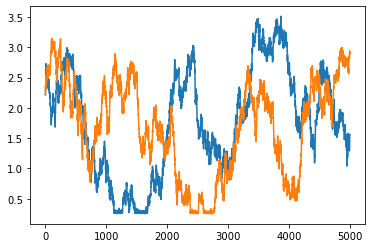

In [65]:
h=plumed.read_as_pandas("HILLS_1")
plt.plot(h.d)
h=plumed.read_as_pandas("HILLS_2")
plt.plot(h.d)

Looking at the number of events, it doesn't seem useful.

I try to remove one variable to make the calculation 1D, and to restrict the domain by using walls.

In [32]:
with open("plumed-d3.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL
cn: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=10

PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
METAD ARG=d SIGMA=0.05 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0 GRID_MAX=4
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-d3.dat -nsteps 500000 -ntomp 12 -pin on",1)

! mv HILLS HILLS_3
! mv traj_comp.xtc traj_comp3.xtc

with open("plumed-d4.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL 

PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
UPPER_WALLS ARG=d AT=1.5 KAPPA=1000.0
METAD ARG=d SIGMA=0.05 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0 GRID_MAX=4
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-d4.dat -nsteps 500000 -ntomp 12 -pin on",1)

! mv HILLS HILLS_4
! mv traj_comp.xtc traj_comp4.xtc

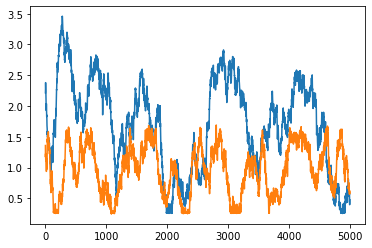

In [33]:
h=plumed.read_as_pandas("HILLS_3")
plt.plot(h.d)
h=plumed.read_as_pandas("HILLS_4")
plt.plot(h.d)

It seems the coordination number was not really needed for this problem. I can also see that by restricting the domain I can observe more events.

In [34]:
!plumed sum_hills --hills HILLS_3 --outfile fes3.dat
!plumed sum_hills --hills HILLS_4 --outfile fes4.dat

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where approp

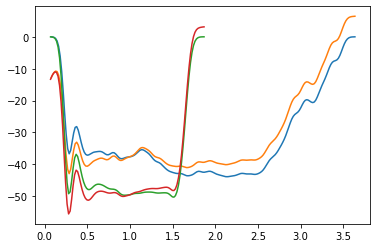

In [35]:
fes3=plumed.read_as_pandas("fes3.dat")
fes4=plumed.read_as_pandas("fes4.dat")
plt.plot(fes3.d,fes3["file.free"])
plt.plot(fes3.d,fes3["file.free"]+2*2.5*np.log(fes3.d))
plt.plot(fes4.d,fes4["file.free"])
plt.plot(fes4.d,fes4["file.free"]+2*2.5*np.log(fes4.d))

I notice that perhaps the bound minimum is narrower than expected, I thus try to decrease hills width. Notice that I am not explicitly computing the stddev of the variable here, probably that would have been wiser.

In [36]:
with open("plumed-d5.dat","w") as f:
    print("""
# vim:ft=plumed
DEBUG DETAILED_TIMERS
NA: GROUP ATOMS=1 
CL: GROUP ATOMS=2 
WAT: GROUP ATOMS=3-8544:3 
d: DISTANCE ATOMS=NA,CL
cn: COORDINATION GROUPA=NA GROUPB=WAT SWITCH={RATIONAL R_0=0.3 D_MAX=0.75} NLIST NL_CUTOFF=0.8 NL_STRIDE=10

PRINT ARG=d,cn STRIDE=100 FILE=COLVAR
UPPER_WALLS ARG=d AT=1.5 KAPPA=1000.0
METAD ARG=d SIGMA=0.025 HEIGHT=1.0 PACE=100 BIASFACTOR=5 GRID_MIN=0 GRID_MAX=4
    """,file=f)
run_mpi("gmx_mpi mdrun -plumed plumed-d5.dat -nsteps 500000 -ntomp 12 -pin on",1)

! mv HILLS HILLS_5
! mv traj_comp.xtc traj_comp5.xtc

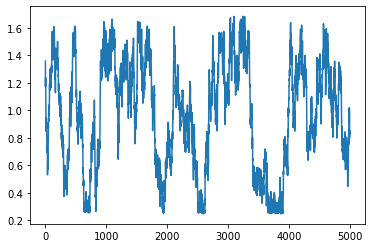

In [37]:
h=plumed.read_as_pandas("HILLS_5")
plt.plot(h.d)

In [38]:
!plumed sum_hills --hills HILLS_5 --outfile fes5.dat

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where approp

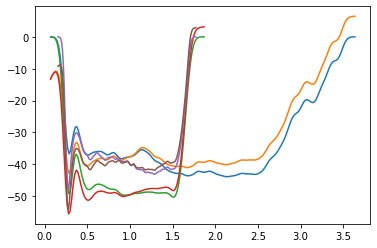

In [39]:
fes3=plumed.read_as_pandas("fes3.dat")
fes4=plumed.read_as_pandas("fes4.dat")
fes5=plumed.read_as_pandas("fes5.dat")
plt.plot(fes3.d,fes3["file.free"])
plt.plot(fes3.d,fes3["file.free"]+2*2.5*np.log(fes3.d))
plt.plot(fes4.d,fes4["file.free"])
plt.plot(fes4.d,fes4["file.free"]+2*2.5*np.log(fes4.d))
plt.plot(fes5.d,fes5["file.free"])
plt.plot(fes5.d,fes5["file.free"]+2*2.5*np.log(fes5.d))

0.1 m = 1e8 nm

1 L = 1e24 nm

1 L / NA = 1e24 / 6.02214076e23 = 1.6605390671738467

In [40]:
def deltaG(fes,dbound,dmin,dmax):
    bound=np.sum(np.exp(-np.array(fes["file.free"])[np.where(fes.d<dbound)]/2.5))
    unbound=np.sum(np.exp(-np.array(fes["file.free"])[np.where(np.logical_and(fes.d>dmin,fes.d<dmax))]/2.5))
    Vunbound=4/3*np.pi*(dmax**3-dmin**3)
    V0=1.66
    unbound /= (Vunbound/V0)
    return -2.5*np.log(bound/unbound)
deltaG(fes5,0.4,1.0,1.4)

-2.404061958790893

It seems I have a reasonable setup. I will then run it for 10 ns.

In [41]:
run_mpi("gmx_mpi mdrun -plumed plumed-d5.dat -nsteps 5000000 -ntomp 12 -pin on",1)

! mv HILLS HILLS_5L
! mv traj_comp.xtc traj_comp5L.xtc

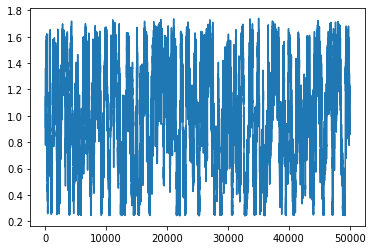

In [42]:
h=plumed.read_as_pandas("HILLS_5L")
plt.plot(h.d)

In [43]:
!plumed sum_hills --hills HILLS_5L --outfile fes5l.dat

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed
PLUMED: For installed feature, see /net/sbp/sbpstore1/bussi/miniconda3/envs/masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where approp

In [66]:
fes5l=plumed.read_as_pandas("fes5l.dat")

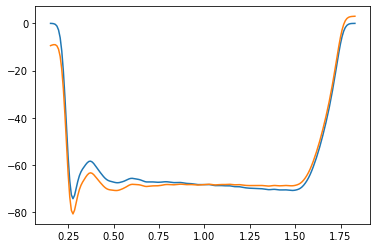

In [67]:
plt.plot(fes5l.d,fes5l["file.free"])
plt.plot(fes5l.d,fes5l["file.free"]+2*2.5*np.log(fes5l.d))

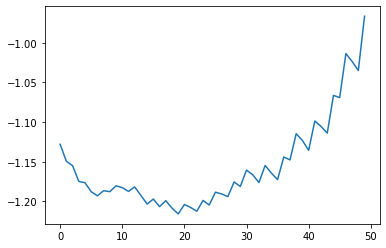

In [68]:
dg=[]
for dmin in np.linspace(0.5,1.2):
    dg.append(deltaG(fes5l,0.4,dmin,1.4))
plt.plot(dg)

Now I try to compute the statistical error with bootstrap. In order to avoid any issues with the tails of the Gaussian, I recompute the weights on the sampled frames rather than relying on sum_hills.

In [194]:
with open("plumed-d5-rew.dat","w") as f:
    print("""
# vim:ft=plumed
d: READ FILE=HILLS_5L VALUES=d IGNORE_FORCES IGNORE_TIME
walls: UPPER_WALLS ARG=d AT=1.5 KAPPA=1000.0
metad: METAD ARG=d SIGMA=0.025 HEIGHT=0.0 PACE=1000000 BIASFACTOR=5 GRID_MIN=0 GRID_MAX=4 RESTART=YES TEMP=300 FILE=HILLS_5L
PRINT FILE=5rew ARG=d,*.bias
    """,file=f)
run_mpi("env PLUMED_NUM_THREADS=12 plumed driver --plumed plumed-d5-rew.dat --noatoms",1)

CompletedProcess(args='\nmodule load intel/2021.1 gcc openmpi3 cuda\nexport PLUMED_KERNEL=/scratch/bussi/masterclass-21-7/install/lib/libplumedKernel.so\nexport LD_LIBRARY_PATH=/scratch/bussi/masterclass-21-7/install/lib:$LD_LIBRARY_PATH\nexport PATH=/scratch/bussi/masterclass-21-7/install/bin:$PATH\nmpiexec -np 1 env PLUMED_NUM_THREADS=12 plumed driver --plumed plumed-d5-rew.dat --noatoms\n', returncode=0)

In [195]:
rew=plumed.read_as_pandas("5rew")
rew

,time,d,walls.bias,metad.bias
0,0.0,1.358092,0.0,56.267298
1,1.0,1.170820,0.0,55.257055
2,2.0,1.194342,0.0,55.287387
3,3.0,1.246570,0.0,55.761400
4,4.0,1.199585,0.0,55.328445
...,...,...,...,...
49995,49995.0,1.011854,0.0,54.536266
49996,49996.0,0.983508,0.0,54.556476
49997,49997.0,0.874258,0.0,53.886100
49998,49998.0,0.949246,0.0,54.457901


In [196]:
d=np.array(rew.d)
w=np.array(np.exp(rew["metad.bias"]/2.5))

In [197]:
def deltaG(d,w,dbound,dmin,dmax):
    bound=np.sum((d<dbound)*w)
    unbound=np.sum(np.logical_and(d>dmin,d<dmax)*w)
    Vunbound=4/3*np.pi*(dmax**3-dmin**3)
    V0=1.66
    unbound /= (Vunbound/V0)
    return -2.5*np.log(bound/unbound)
deltaG(d,w,0.4,1.0,1.4)

-0.1520605743636633

In [198]:
# block bootstrap with 10 blocks
dG=[]
NB=10
for i in range(1000):
    c=np.random.choice(NB,NB)
    dd=d.reshape((NB,-1))[c].flatten()
    ww=w.reshape((NB,-1))[c].flatten()
    dG.append(deltaG(dd,ww,0.4,1.0,1.4))

In [199]:
np.average(dG),np.std(dG)

(-0.1308196279234411, 0.30001299263974845)

The standard binding free energy is very close to zero, within its error. Notice that a value of zero has no particular meaning, since it arbitrarily depends on the definition of a molar volume. Also notice that computing the affinity using the actual values (rather than sum_hills) is more reliable, since it allows to detect if the ions are before or after the first energy barrier without any effect from the Gaussian tails.